In [5]:
from dataclasses import dataclass
import enum
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
from IPython.display import Markdown
import itertools
from matplotlib import gridspec, pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from db import Database, get_df

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats


set_matplotlib_formats('svg')


pd.set_option('display.max_rows', None)


def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)
    

@dataclass()
class SigmaMu:
    mu: float
    sigma: float
    pass


class SimulateMode(enum.Enum):
    NORMAL = 0,
    NEGATIVE_BINOMIAL = 1
    pass


@dataclass()
class SimulateParams:
    fp: SigmaMu
    tp: SigmaMu
    mode: SimulateMode
    pass


def simulate(params: SimulateParams, n=30*24, p=10*24):
    if params.mode == SimulateMode.NORMAL:
        fps = np.random.normal(loc=params.fp.mu, scale=params.fp.sigma, size=n)
        tps = np.random.normal(loc=params.tp.mu, scale=params.tp.sigma, size=p)
    elif params.mode == SimulateMode.NEGATIVE_BINOMIAL:
        _r,_p = neg_rp(params.fp.mu, params.fp.sigma)
        fps = np.random.negative_binomial(_r, _p, size=n)
        _r,_p = neg_rp(params.tp.mu, params.tp.sigma)
        tps = np.random.negative_binomial(_r, _p, size=p)
        pass

    tps = np.concatenate([np.zeros(n-p), tps])
    labels = np.concatenate([np.zeros(n-p), np.ones(p)])

    fpr, tpr, thresholds = roc_curve(labels, (fps + tps))
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax((tpr - fpr)) # np.argmax((fpr < 0.05) * (tpr - fpr))

    roc_auc_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)
    optimal_idx_fpr001 = np.argmax((fpr < 0.01) * (tpr - fpr))

    th_001_range = (fpr < 0.01).sum() / len(fpr)

    return th_001_range, thresholds[optimal_idx], fpr[optimal_idx], tpr[optimal_idx], thresholds[optimal_idx_fpr001], fpr[optimal_idx_fpr001], tpr[optimal_idx_fpr001], roc_auc, roc_auc_001

def simulate_montecarlo(N, sp: SimulateParams, n=30*24, p=10*24):
    res = []
    for i in range(N):
        _ = simulate(sp, n, p)
        res.append(_)
        pass
    return pd.DataFrame(res, columns="th_001_range,th,fpr,tpr,th_001,fpr_001,tpr_001,roc_auc,roc_auc_001".split(','))

def simulate_montecarlo_mean(N, sp: SimulateParams, n=30*24, p=10*24):
    df = simulate_montecarlo(N, sp, n, p)
    th,fpr,tpr,roc_auc = df.mean().to_list()
    return th,fpr,tpr,roc_auc

def simulate_loop(mu_fp, mu_tp_ratio, sm: SimulateMode):
    res = []
    sigma_props_fp=map(lambda x: x*1.0/10.0+0.2, range(1, 11, 1))
    sigma_props_tp=map(lambda x: x*1.0/10.0+0.2, range(1, 11, 1))
    for sigma_fp_prop, sigma_tp_prop in list(itertools.product(sigma_props_fp, sigma_props_tp)):
        sp = SimulateParams(SigmaMu(mu_fp, mu_fp * sigma_fp_prop), SigmaMu(mu_fp * mu_tp_ratio, mu_fp * mu_tp_ratio * sigma_tp_prop), sm)
        th, fpr, tpr, roc_auc = simulate_montecarlo(10, sp)
        res.append([sigma_fp_prop, sigma_tp_prop, th, fpr, tpr, roc_auc])
        pass
    return pd.DataFrame(res, columns='sigma_fp/mu_fp,sigma_tp/mu_tp,th,fpr,tpr,roc_auc'.split(','))


# Simulazione con distribuzione normale

Le strisce verticali indicano come la $\sigma_{fp}$ influisca pesantemente
nella roc_auc. Contrariamente, $\sigma_{tp}$ influenza quasi minimamente
roc_auc.

Come è ovvio che sia, il rapporto $\mu_{tp}/\mu_{fp}$ implica che la roc_auc
acquisisca valori migliori tanto più quanto quest'ultimo ha valori crescenti.

Sebbene sia ovvio che $\mu_{fp}$ e $\mu_{tp}$ possano avere un'influenza
considerevole, non lo è per quanto riguarda le varianze, soprattutto per quanto
riguarda $\sigma_{fp}$.

## ROC_AUC

Tale parametro è tanto migliore quanto più è prossimo ad uno. Nel caso si
avvicini a 0.5, indica un classificatore _inutile_, ovvero il cui esito è
equivalente al lancio di una moneta.

La curva ROC è utilizzata per capire le perfomance di un classificatore binario:
essa mostra il rapporto ottenuto tra FPR e TPR per tutti i possibili valori di
soglia, calcolati dalla funzione `roc_curve`.

In [ ]:

fig = plt.figure(figsize=(12,6))
for k, mu_fp in enumerate([50, 100]):
    gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0.05)  # 4 quadranti per le heatmap, 1 per la colormap

    for i, mu_tp_ratio in enumerate([0.1, 0.4, 0.8, 1.0, 1.2]):
        if i == 0:
            ax = fig.add_subplot(gs[k, i])
        else:
            ax = fig.add_subplot(gs[k, i])#, sharey=ax0)

        df = simulate_loop(mu_fp, mu_tp_ratio, SimulateMode.NORMAL).round(4).sort_index()
        df = df.pivot(columns='sigma_fp/mu_fp', index='sigma_tp/mu_tp', values='roc_auc')

        if i == 4:
            cbar_ax = fig.add_subplot(gs[k, 5])
        else:
            cbar_ax = ax

        ax = sns.heatmap(df.sort_index(ascending=False), ax=ax, cbar=i==4, cbar_ax=cbar_ax, vmin=0.5, vmax=1.0, cmap=sns.color_palette("rocket", n_colors=6)) # type: ignore
        if k == 0:
            ax.set_xticks([])
        if i > 0:
            ax.set_ylabel('')
            # ax.set_yticks([x/10 + 0.5 for x in range(10)],
            # np.linspace(0,1,10))
            ax.set_yticks([])
            pass
        else:
            ax0 = ax
            pass
        if k == 0 or i != 2:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('$\\sigma_{fp}/\\mu_{fp}$')
        # if i == 2:
        #     ax.set_title(f'mu_fp={mu_fp}', size='small')
        if i == 0:
            ax.set_ylabel(f'$\\mu_{{fp}}={mu_fp}$\n\n$\\sigma_{{tp}}/\\mu_{{tp}}$', size='small')

        if k == 0:
            ax.set_title(f'$\\mu_{{fp}}/\\mu_{{tp}}={mu_tp_ratio}$, $\\mu_{{tp}}={mu_tp_ratio * mu_fp}$', size='small')
        ax.tick_params(labelsize='small')
        pass

    if k == 1:
        cbar_ax.set_xlabel('roc_auc')
        pass
    cbar_ax.set_yticks([ x*0.5/6 + 0.5 + 0.5/12 for x in range(6)], '0.5,0.6,0.7,0.8,0.9,1.0'.split(','))
    pass



In [33]:
mu_fp = 100
dfs = []
for mus_ratio in [0.5, 1.0, 1.5]:
    for sigma_tp_ratio in [0.1, 0.5, 1, 4, 8]:
        for sigma_fp_ratio in [0.1, 0.5, 1, 4, 8]: #np.linspace(0.0, 4.0, 10):
            sigmamu_fp = SigmaMu(mu_fp, mu_fp * sigma_fp_ratio)
            mu_tp = sigmamu_fp.mu * mus_ratio
            sigmamu_tp = SigmaMu(mu_tp, mu_tp * sigma_tp_ratio)
            sp = SimulateParams(sigmamu_fp, sigmamu_tp, SimulateMode.NORMAL)

            df = simulate_montecarlo(2, sp)

            df['mus_ratio'] = mus_ratio
            df['sigma_fp_ratio'] = sigma_fp_ratio
            df['sigma_tp_ratio'] = sigma_tp_ratio
            dfs.append(df)

            pass

DF = pd.concat(dfs)

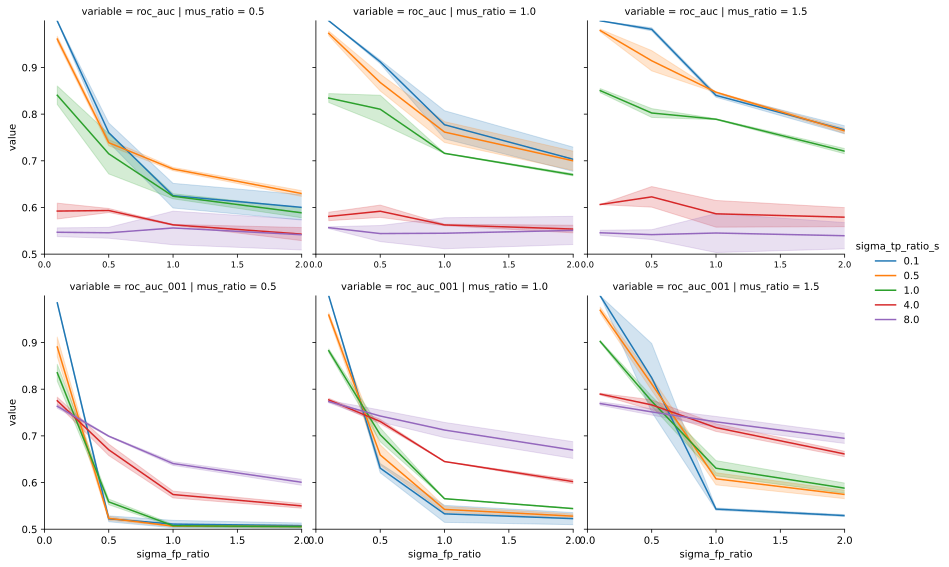

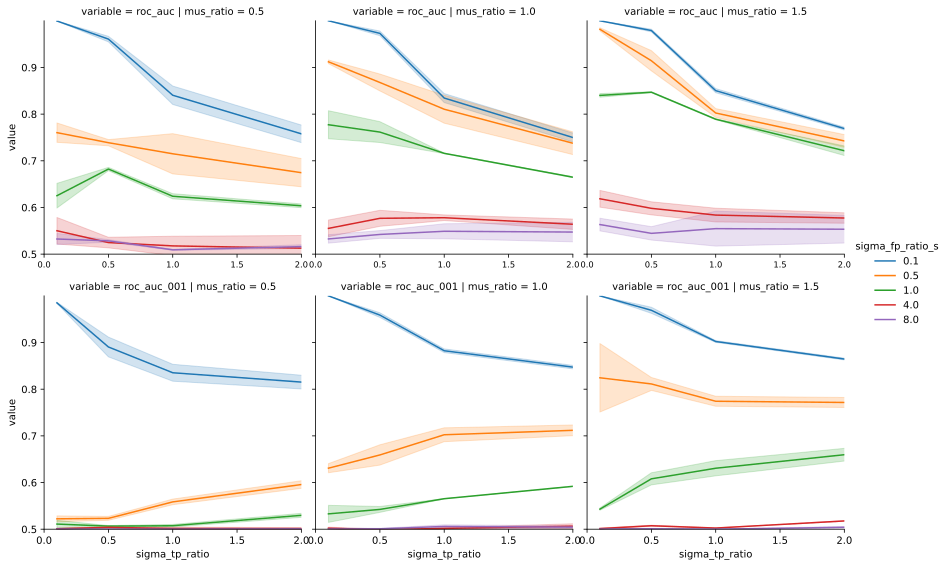

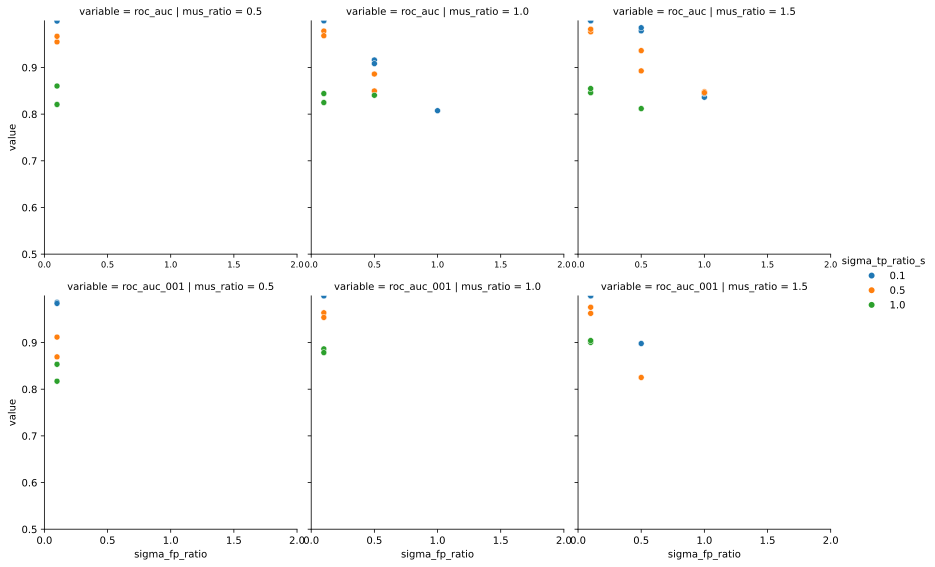

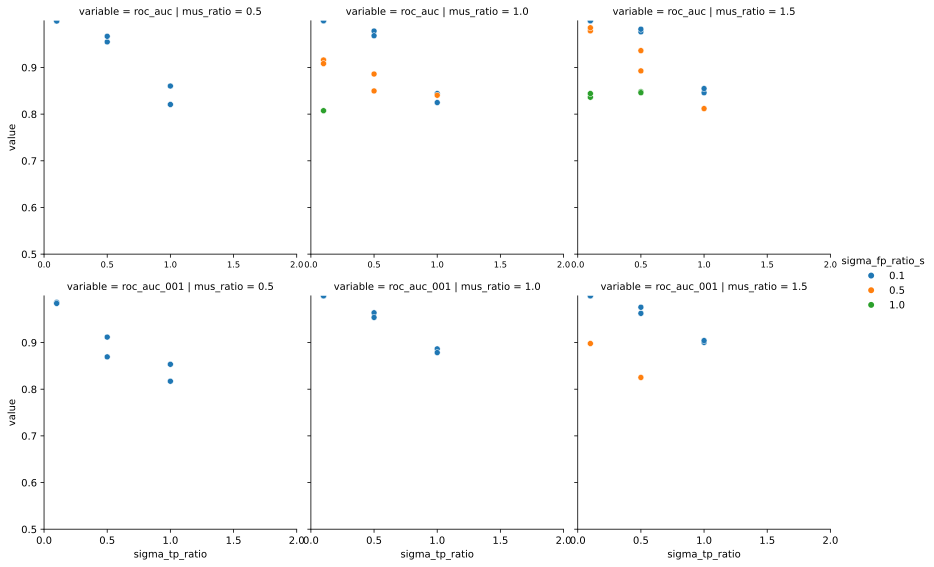

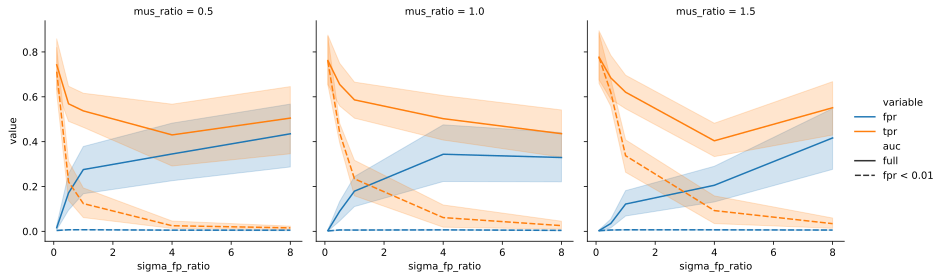

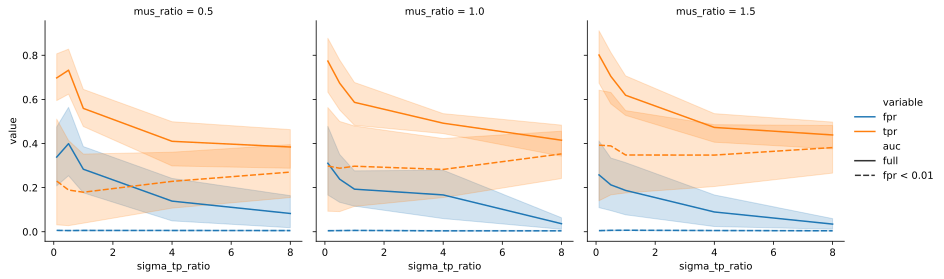

In [34]:

df = DF.melt(id_vars=['th', 'th_001_range', 'th_001', 'fpr_001', 'tpr_001', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio', 'roc_auc', 'roc_auc_001'], value_vars=['fpr','tpr'])#.head(50)

_col='mus_ratio'

xmax = 2.0
xstep = 0.5
xticks = list(map(lambda x: xstep * x, range(int((xmax + 0.1)/xstep)))) + [xmax]

df = df[df['mus_ratio'] > 0.1]

df = DF.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['roc_auc', 'roc_auc_001'])
df['sigma_tp_ratio_s'] =df['sigma_tp_ratio'].astype(str)
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", row='variable', col=_col, hue='sigma_tp_ratio_s',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]


df['sigma_fp_ratio_s'] =df['sigma_fp_ratio'].astype(str)
g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", row='variable', col=_col, hue='sigma_fp_ratio_s',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['roc_auc', 'roc_auc_001'])
df['sigma_tp_ratio_s'] =df['sigma_tp_ratio'].astype(str)
g = sns.relplot(
    data=df[df['value'] > 0.8], kind="scatter",
    x="sigma_fp_ratio", y="value", row='variable', col=_col, hue='sigma_tp_ratio_s',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]


df['sigma_fp_ratio_s'] =df['sigma_fp_ratio'].astype(str)
g = sns.relplot(
    data=df[df['value'] > 0.8], kind="scatter",
    x="sigma_tp_ratio", y="value", row='variable', col=_col, hue='sigma_fp_ratio_s',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr', 'fpr_001', 'tpr', 'tpr_001'])




df['auc'] = (df['variable'].str.find('_001') >= 0).apply(lambda x: 'fpr < 0.01' if x else 'full')
df['variable'] = df['variable'].str[0:3]



g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)



g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)

In [15]:


# Obiettivo: trovare i parametri ottimali per ottenere P(FP) = 0.35
def get_th(mu_fp, sigma_fp, FP_min, th_init):
    target_FP = FP_min

    # Funzione obiettivo per ottimizzare più parametri
    def objective(params, target_FP):
        th = params
        
        # Calcola P(FP)
        P_FP = 1 - norm.cdf(th, loc=mu_fp, scale=sigma_fp)
        
        # L'obiettivo è minimizzare la differenza assoluta tra P(FP) e il target desiderato
        return abs(P_FP - target_FP)

    # Inizializzazione con valori iniziali per i parametri
    initial_params = [th_init]  # mu_fp, sigma_fp, th

    # Minimizzazione per trovare i migliori valori di mu_fp, sigma_fp e th
    result = minimize(objective, x0=initial_params, args=(target_FP,), method='Nelder-Mead')

    # Output dei risultati
    optimal_th, = result.x
    optimal_FP = 1 - norm.cdf(optimal_th, loc=mu_fp, scale=sigma_fp)

    # print(f"Fixed mu_fp: {mu_fp:.4f}")
    # print(f"Fixed sigma_fp: {sigma_fp:.4f}")
    # print(f"Optimal th: {optimal_th:.4f}")
    # print(f"Resulting P(FP): {optimal_FP:.4f}\n")
    return optimal_th, optimal_FP


# Obiettivo: trovare i parametri ottimali per ottenere P(FP) = 0.35
def get_optimal_mu_tp(mu_fp, sigma_fp, th, sigma_tp, target_TP, mu_tp=100):

    # Funzione obiettivo per ottimizzare più parametri
    def objective(params, target_TP):
        mu_tp = params
        
        # Calcola P(FP)
        P_TP = 1 - norm.cdf(th - (mu_fp - sigma_fp), loc=mu_tp, scale=sigma_tp)
        
        # L'obiettivo è minimizzare la differenza assoluta tra P(FP) e il target desiderato
        return abs(P_TP - target_TP)

    # Inizializzazione con valori iniziali per i parametri
    initial_params = [mu_tp]  # mu_tp, sigma_tp

    # Minimizzazione per trovare i migliori valori di mu_fp, sigma_fp e th
    result = minimize(objective, x0=initial_params, args=(target_TP,), method='Nelder-Mead')

    # Output dei risultati
    optimal_mu_tp, = result.x
    optimal_TP = 1 - norm.cdf(th - (mu_fp - sigma_fp), loc=optimal_mu_tp, scale=sigma_tp)

    # print(f"Fixed mu_fp: {mu_fp:.4f}")
    # print(f"Fixed sigma_fp: {sigma_fp:.4f}")
    # print(f"Optimal th: {th:.4f}")
    # print(f"Fixed sigma_tp: {sigma_tp:.4f}")
    # print(f"Optimal mu_tp: {optimal_mu_tp:.4f}")
    # print(f"Optimal mu_tp/mu_fp: {optimal_mu_tp/mu_fp:.4f}")
    # print(f"Resulting P(TP): {optimal_TP:.4f}\n\n")
    return optimal_mu_tp/mu_fp, optimal_TP


def elaborate(mu_fps, sigma_fp_ratios, FP, TP):
    rs = []
    for mu_fp in mu_fps:
        for sigma_fp_ratio in sigma_fp_ratios:
            sigma_fp = mu_fp * sigma_fp_ratio
            th, optimal_FP = get_th(mu_fp, sigma_fp, FP, mu_fp)
            for mu_tp_ratio in [0.1, 0.4, 0.8, 1.0, 1.2]:
                r, optimal_TP = get_optimal_mu_tp(mu_fp, sigma_fp, th, 10, TP, mu_tp=mu_fp * mu_tp_ratio)
                rs.append([
                    mu_fp,
                    mu_tp_ratio * mu_fp,
                    optimal_FP,
                    optimal_TP,
                    sigma_fp_ratio,
                    th/mu_fp,
                    r
                ])
                pass

    return pd.DataFrame(rs, columns=['mu_fp', 'mu_tp', 'optimal_FP', 'optimal_TP', 'sigma_fp_prop', 'th/mu_fp', 'mu_tp/mu_fp']).round(2).set_index(['mu_fp', 'mu_tp', 'optimal_FP', 'optimal_TP', 'sigma_fp_prop', 'th/mu_fp', 'mu_tp/mu_fp'])

display(Markdown('''
In pratica, simulando FP e TP con una distribuzione normale, si envice che: per certi valori di mu_fp e mu_tp, se l'obbiettivo è
avere un certo FPR e un certo TPR, sigma_fp gioca un ruolo determinante.
'''))

_ = elaborate(mu_fps=[100],
          sigma_fp_ratios=map(lambda x: x*1.0/10.0, range(1, 11, 1)),
          FP=0.01, TP=0.8).sort_index()




In pratica, simulando FP e TP con una distribuzione normale, si envice che: per certi valori di mu_fp e mu_tp, se l'obbiettivo è
avere un certo FPR e un certo TPR, sigma_fp gioca un ruolo determinante.


In [28]:
from db import get_df, Database

db = Database()

pcaps = [('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]

for mu_fp in [5, 50, 100]:
    masked = True
    rs = []
    for mwname, pcap_id in pcaps:
        df = get_df(db, mwname, pcap_id, True, 'nx')
        mu_tp = df[df > 0 if masked else df >= 0]['p'].iloc[:30*24].mean()
        sigma_tp = df[df > 0 if masked else df >= 0]['p'].iloc[:30*24].std()

        _r = pow(mu_tp,2)/(pow(sigma_tp,2) - mu_tp)
        _p = mu_tp/pow(sigma_tp,2)

        for sigma_fp_ratio in map(lambda x: x*1.0/10.0, range(1, 11, 2)):
            sigma_fp = mu_fp * sigma_fp_ratio
            th, optimal_FP = get_th(mu_fp, sigma_fp, 0.01, mu_fp*0.9)

            calculated_TP = 1 - norm.cdf(th - (mu_fp - sigma_fp), loc=mu_tp, scale=sigma_tp)

            fps = np.random.normal(mu_fp, sigma_fp, size=30*24)
            tps = df['p'].to_numpy()

            n = tps == 0
            p = tps > 0
            tp = p & ((fps + tps) > th)
            fp = n & ((fps) > th)

            simulated_FP = fp.sum() / n.sum()
            simulated_TP = tp.sum() / p.sum()

            rs.append([
                mu_fp,
                sigma_fp,
                th,
                optimal_FP,
                mwname,
                mu_tp,
                sigma_tp,
                _r,
                _p,
                simulated_FP,
                simulated_TP,
                calculated_TP
            ])
            pass
        pass

    df = pd.DataFrame(rs, columns='mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP'.split(',')).round(2)
    df['delta_TP'] = df['calculated_TP'] - df['simulated_TP']
    df['delta_TP%'] = ((df['calculated_TP'] - df['simulated_TP'])*100).round(0).astype(int)
    display(df)#.sort_values(by='delta_TP'))
    display(df['delta_TP%'].describe())#.sort_values(by='delta_TP'))
    pass

,mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP,delta_TP,delta_TP%
0,5,0.5,6.16,0.01,caphaw,4.73,3.39,3.31,0.41,0.00,0.95,0.82,-0.13,-13
1,5,1.5,8.49,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.58,0.47,-0.11,-11
2,5,2.5,10.82,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.35,0.14,-0.21,-21
3,5,3.5,13.14,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.21,0.02,-0.19,-19
4,5,4.5,15.47,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.14,0.00,-0.14,-14
5,5,0.5,6.16,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.52,0.50,-0.02,-2
6,5,1.5,8.49,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.11,0.15,0.04,4
7,5,2.5,10.82,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.06,0.02,-0.04,-4
8,5,3.5,13.14,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.03,0.00,-0.03,-3
9,5,4.5,15.47,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.03,0.00,-0.03,-3


count    20.000000
mean     -4.650000
std      13.452744
min     -27.000000
25%     -15.000000
50%      -3.500000
75%       2.500000
max      19.000000
Name: delta_TP%, dtype: float64

,mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP,delta_TP,delta_TP%
0,50,5.0,61.63,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.13,0.00,-0.13,-13
1,50,15.0,84.90,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.02,0.00,-0.02,-2
2,50,25.0,108.16,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.02,0.00,-0.02,-2
3,50,35.0,131.42,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.01,0.00,-0.01,-1
4,50,45.0,154.69,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.01,0.00,-0.01,-1
5,50,5.0,61.63,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.05,0.00,-0.05,-5
6,50,15.0,84.90,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1
7,50,25.0,108.16,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.02,0.00,-0.02,-2
8,50,35.0,131.42,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1
9,50,45.0,154.69,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1


count    20.000000
mean      2.000000
std       8.233436
min     -13.000000
25%      -2.000000
50%      -1.000000
75%       9.500000
max      18.000000
Name: delta_TP%, dtype: float64

,mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP,delta_TP,delta_TP%
0,100,10.0,123.26,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.04,0.00,-0.04,-4
1,100,30.0,169.79,0.01,caphaw,4.73,3.39,3.31,0.41,0.00,0.02,0.00,-0.02,-2
2,100,50.0,216.32,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.01,0.00,-0.01,-1
3,100,70.0,262.84,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.01,0.00,-0.01,-1
4,100,90.0,309.37,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.01,0.00,-0.01,-1
5,100,10.0,123.26,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.03,0.00,-0.03,-3
6,100,30.0,169.79,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1
7,100,50.0,216.32,0.01,zbot,1.67,3.18,0.33,0.16,0.02,0.01,0.00,-0.01,-1
8,100,70.0,262.84,0.01,zbot,1.67,3.18,0.33,0.16,0.00,0.00,0.00,0.00,0
9,100,90.0,309.37,0.01,zbot,1.67,3.18,0.33,0.16,0.02,0.01,0.00,-0.01,-1


count    20.000000
mean      0.750000
std       7.670003
min     -10.000000
25%      -3.250000
50%      -1.000000
75%       0.500000
max      19.000000
Name: delta_TP%, dtype: float64

In [1]:
from typing import Optional
from db import get_df, Database
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve

slot_h = 0.5

def get_pcaps(slot_h=1.):
    db = Database()

    DF_FP = get_df(db, 'normal', None, True, 'nx', slot_h=slot_h).iloc[0:int(8/slot_h)]

    dfs = {
        'healthy': DF_FP,
        'caphaw': get_df(db, 'caphaw', 54, True, 'nx'),
        'zbot': get_df(db, 'zbot', 46, True, 'nx'),
        'simda': get_df(db, 'simda', 58, True, 'nx'),
        'unknown': get_df(db, 'unknown', 57, True, 'nx'),
    }
    return dfs

def simulate_pcaps(dfs, slot_h, window_slots, fp_simulate=False, fp_copies=1, sigma_fp_ratio=1.0, mus_ratios=[0.5,1.0,1.5]):
    df_fp = pd.concat([dfs['healthy'].copy() for _ in range(fp_copies)], axis=0).reset_index(drop=True)

    if not fp_simulate:
        window_slots = df_fp.shape[0]

    res = []
    for mw in dfs:
        if mw == 'healthy':
            continue
        df_tp = dfs[mw]
        skipped_all = 0
        skipped_any = 0
        for w in range(0, int(24*30/slot_h)):
            tps = df_tp.iloc[w:w + window_slots]['pp'].reset_index(drop=True)
            if tps.shape[0] < window_slots:
                break
            fpss = []
            if fp_simulate:
                for mus_ratio in mus_ratios:
                    mu_fp = tps.mean() / mus_ratio
                    fpss.append((mu_fp, mu_fp * sigma_fp_ratio, np.random.normal(mu_fp, mu_fp * sigma_fp_ratio, tps.shape[0])))
            else:
                fpss = [(df_fp['pp'].mean(), df_fp['pp'].std(), df_fp['pp'])]

            for mu_fp, sigma_fp, fps in fpss:
                labels = tps > 0

                if labels.all() or labels.any() == False:
                    skipped_all += labels.all()
                    skipped_any += labels.any() == False
                    continue


                fpr, tpr, thresholds = roc_curve(labels, (fps + tps))
                roc_auc = auc(fpr, tpr)
                optimal_idx = np.argmax((tpr - fpr))

                roc_auc_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)
                optimal_idx_fpr001 = np.argmax((fpr < 0.01) * (tpr - fpr))

                th_001_range = (fpr < 0.01).sum() / len(fpr)

                res.append([
                    mw,
                    w,
                    mu_fp,
                    sigma_fp,
                    tps.mean(),
                    tps.std(),
                    th_001_range,
                    thresholds[optimal_idx],
                    fpr[optimal_idx],
                    tpr[optimal_idx],
                    roc_auc,
                    thresholds[optimal_idx_fpr001],
                    fpr[optimal_idx_fpr001],
                    tpr[optimal_idx_fpr001],
                    roc_auc_001
                ])
                pass
            pass
        pass

    DF = pd.DataFrame(res, columns=[
        'mw',
        'w',
        'mu_fp',
        'sigma_fp',
        'mu_tp',
        'sigma_tp',
        'th_001_range',
        'thresholds',
        'fpr',
        'tpr',
        'roc_auc',
        'thresholds_001',
        'fpr_001',
        'tpr_001',
        'roc_auc_001'
    ])

    DF['mus_ratio'] = DF['mu_tp'] / DF['mu_fp']
    DF['sigma_fp_ratio'] = DF['sigma_fp'] / DF['mu_fp']
    DF['sigma_tp_ratio'] = DF['sigma_tp'] / DF['mu_tp']

    return DF


In [117]:
from math import ceil


if True:
    dfs = get_pcaps(0.5)


df = simulate_pcaps(dfs, 0.5, 16)

df = (df[['mw','w','mus_ratio', 'sigma_fp', 'sigma_tp', 'sigma_fp_ratio', 'sigma_tp_ratio','th_001_range','fpr_001','tpr_001','roc_auc_001']]).round(2)


# sns.relplot(df, x='sigma_tp_ratio', y='roc_auc_001', row='mus_ratio', kind='scatter', height=3, aspect=3)


df = df[df['mus_ratio'] < 10]
# df['sigma_tp_ratio'] = pd.cut(df['sigma_tp_ratio'], 10, include_lowest=True)
# df['mus_ratio'] = pd.cut(df['mus_ratio'], 20, include_lowest=True)
df['mus_ratio'] = pd.cut(df['mus_ratio'], 5, duplicates='drop')

# for mus_ratio in df['mus_ratio'].dtype.categories:
#     print(mus_ratio)
#     _df = df[df['mus_ratio'] == mus_ratio].copy()
#     _df['sigma_tp_ratio'] = pd.qcut(_df['sigma_tp_ratio'], 10, duplicates='drop')
#     dfg = _df[['sigma_tp_ratio', 'mus_ratio', 'roc_auc_001', 'tpr_001']].groupby(['mus_ratio','sigma_tp_ratio'], observed=False).agg(['count','mean','std'])
#     display(dfg.dropna())
#     pass

df = df.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr_001', 'tpr_001'])

# sns.relplot(df, x='sigma_fp_ratio', y='value', hue='variable', col='mus_ratio')


In [3]:
import pandas as pd

slot_h = 0.5

if True:
    pcaps = get_pcaps(slot_h)

for i in [10, 20, 40][::-1]:
    dfs = []
    for N in range(4):
        print(N, i)
        for sigma_fp_ratio in np.linspace(0.1, 4, i):
            
            df = simulate_pcaps(pcaps, slot_h, 16, fp_simulate=True, sigma_fp_ratio=sigma_fp_ratio, mus_ratios=[0.5,1.0,1.5])

            df = (df[['mw','w','mus_ratio', 'sigma_fp', 'sigma_tp', 'sigma_fp_ratio', 'sigma_tp_ratio','th_001_range','fpr_001','tpr_001','roc_auc_001']]).round(2)

            dfs.append(df)

            pass

    df = pd.concat(dfs, axis=0)

    DF = df

    DF.to_csv(f'DF_{i}.csv')


    pass

0 40
1 40
2 40
3 40
0 20
1 20
2 20
3 20
0 10
1 10
2 10
3 10


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_28368/872068886.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df[['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin']).mean().reset_index()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_28368/872068886.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df[['mw', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['mw', 'mus_ratio', 'sigma_fp_ratio',  'sigma_tp_ratio_bin']).mean().reset_index()


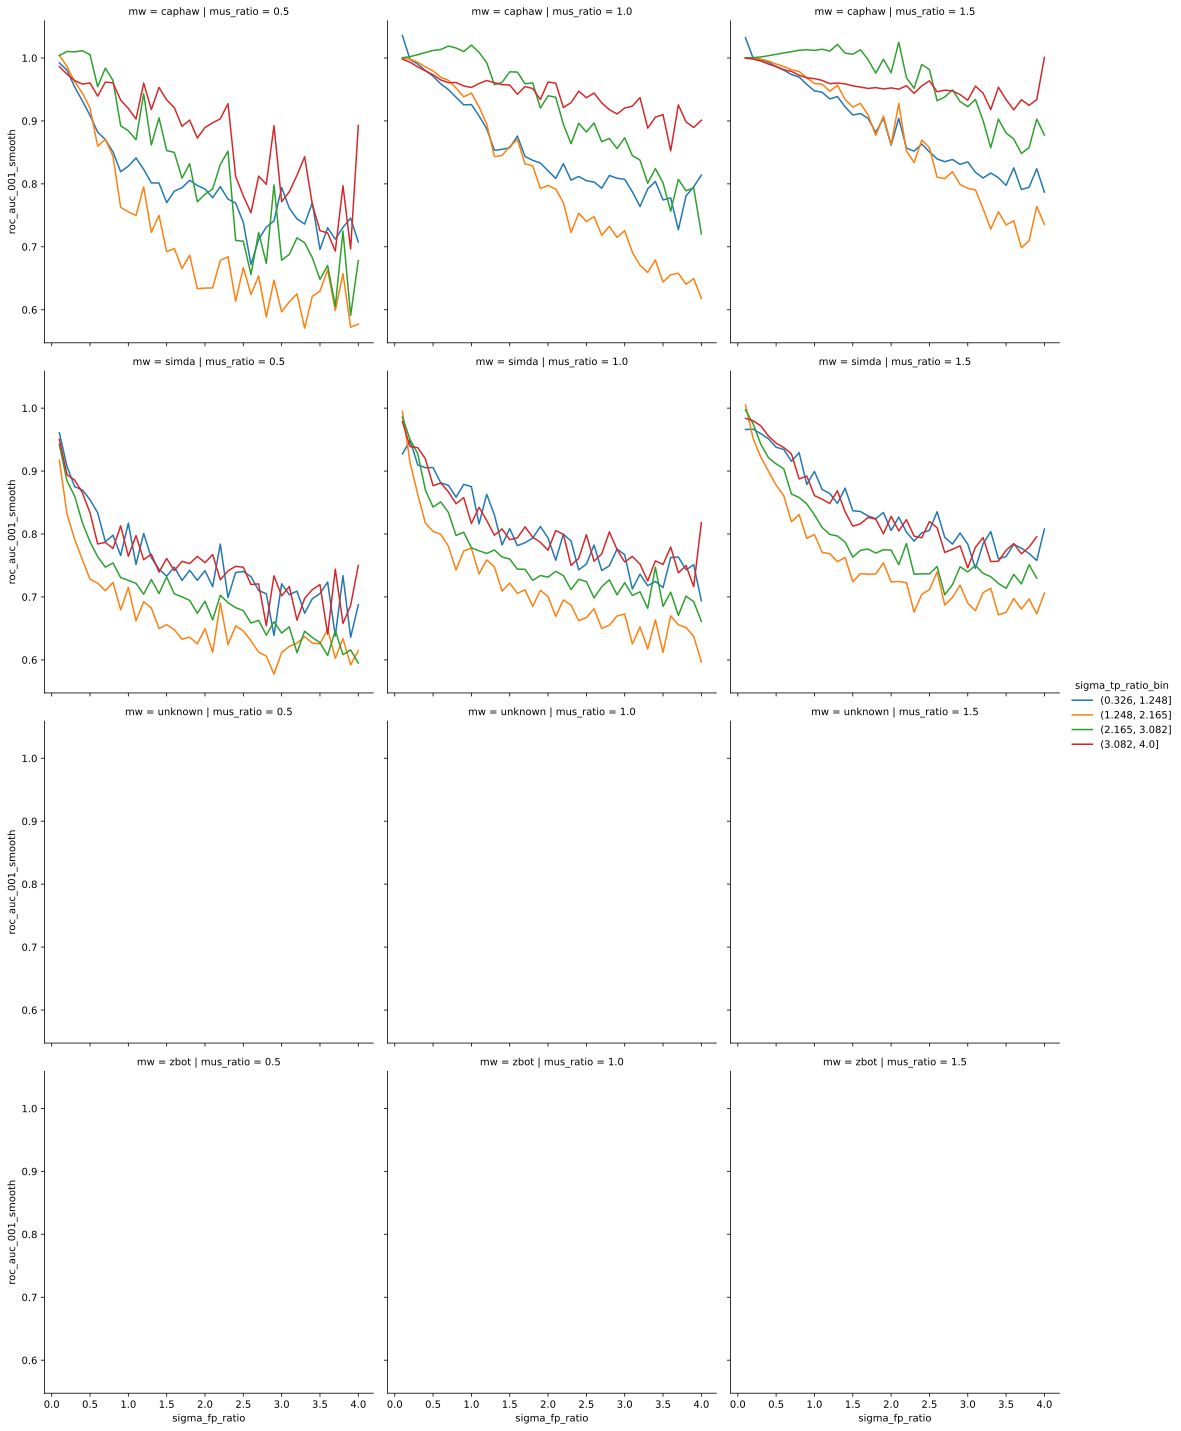

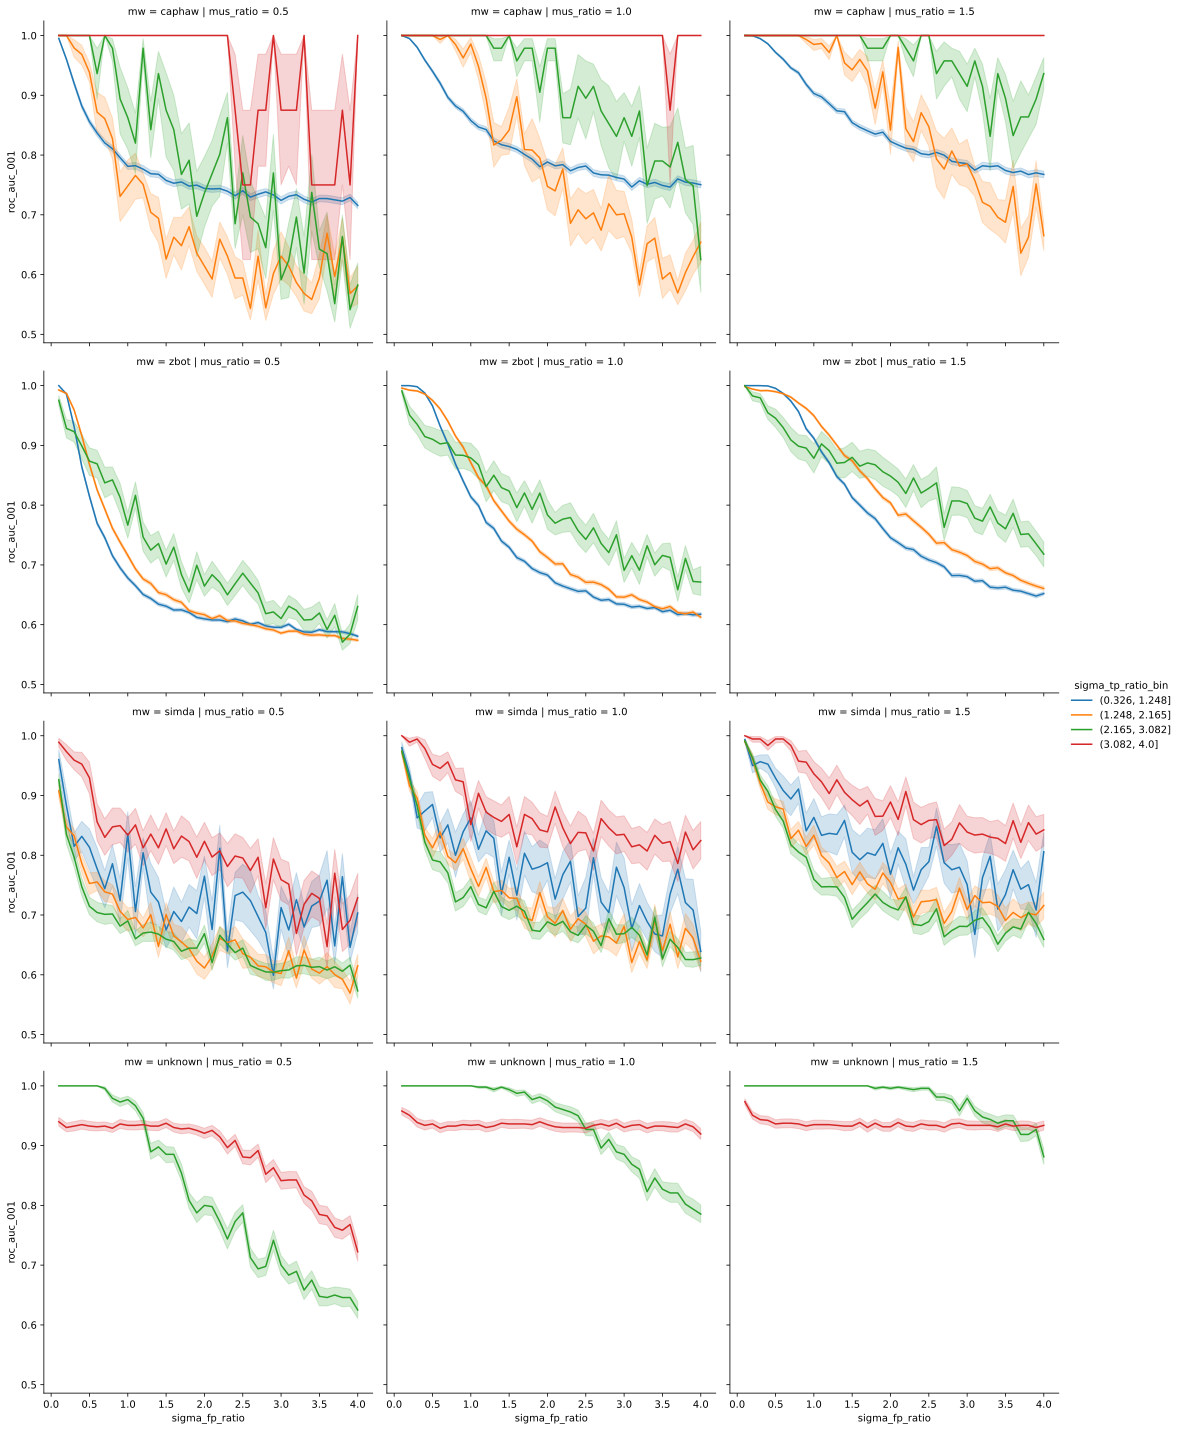

In [9]:

df = pd.read_csv('DF_40.csv', index_col=None)

ii = pd.IntervalIndex.from_breaks([0.5, 1, 5, 10, 100], closed='right')

# df['mus_ratio'] = pd.cut(df['mus_ratio'], bins=ii)

tmp = df['sigma_tp_ratio'].copy()

df['sigma_tp_ratio_bin'] = pd.cut(tmp, 4, duplicates='drop')
df['sigma_tp_ratio_qcut_bin'] = pd.qcut(tmp, 4, duplicates='drop')

# # df['mus_ratio_bin'] = pd.qcut(df['mus_ratio'], 6, duplicates='drop')
# pivot_table = df.pivot_table(index='sigma_tp_ratio_bin', columns='mus_ratio_bin', values='fpr_001', aggfunc='count')
# print(pivot_table)


# df = df.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio','sigma_tp_ratio_qcut'], value_vars=['fpr_001', 'tpr_001'])

dfg = df[['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin']).mean().reset_index()


# df = df[df.mus_ratio_bin in []]

# df = df[df['mus_ratio'].apply(lambda x: x in df.mus_ratio_bin.cat.categories[2:])]

# sns.relplot(dfg, x='sigma_fp_ratio', y='roc_auc_001', kind='line',
# hue='sigma_tp_ratio_bin', col='mus_ratio_bin')

if True:
    from scipy.signal import savgol_filter
    import numpy as np
    import matplotlib.pyplot as plt

    # Dati di esempio
    x = np.linspace(0, 10, 100)
    y = np.sin(x) + np.random.normal(0, 0.5, size=x.shape)

    dfg = df[['mw', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['mw', 'mus_ratio', 'sigma_fp_ratio',  'sigma_tp_ratio_bin']).mean().reset_index()

    # Applica il filtro di Savitzky-Golay
    dfg['roc_auc_001_smooth'] = savgol_filter(dfg['roc_auc_001'], window_length=5, polyorder=2)

    sns.relplot(dfg, x='sigma_fp_ratio', y='roc_auc_001_smooth', kind='line', hue='sigma_tp_ratio_bin', col='mus_ratio', row='mw')
    
    pass

__df = pd.concat([df.copy() for _ in range(4)], axis=0)

sns.relplot(__df, x='sigma_fp_ratio', y='roc_auc_001', kind='line', hue='sigma_tp_ratio_bin', col='mus_ratio', row='mw')


# sns.relplot(df[df['variable'] == 'tpr_001'], x='sigma_fp_ratio', y='value',
# kind='line', hue='sigma_tp_ratio_qcut', col='mus_ratio')



In [ ]:

df = DF.melt(id_vars=['mw', 'th_001_range', 'fpr_001', 'tpr_001', 'sigma_fp_ratio', 'sigma_tp_ratio', 'roc_auc', 'roc_auc_001'], value_vars=['fpr','tpr'])#.head(50)

_col='mw'

xmax = 2.0
xstep = 0.5
xticks = list(map(lambda x: xstep * x, range(int((xmax + 0.1)/xstep)))) + [xmax]

df = DF.melt(id_vars=['mw', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['roc_auc', 'roc_auc_001'])
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=['mw', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr', 'fpr_001', 'tpr', 'tpr_001'])




df['auc'] = (df['variable'].str.find('_001') >= 0).apply(lambda x: 'fpr < 0.01' if x else 'full')
df['variable'] = df['variable'].str[0:3]



g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)



g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)


In [62]:
def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)

res = []
for mu, sigma_ratio in itertools.product([5, 50, 100], map(lambda x: x/10 + 0.5, range(1,10))):
    sigma = mu*sigma_ratio
    _r, _p= neg_rp(mu, sigma)
    res.append([
        mu, sigma, sigma_ratio, _r, _p
    ])

df = pd.DataFrame(res, columns='mu,sigma,sigma_ratio,_r,_p'.split(','))
print(all(df['_r'] > 0), all(df['_p'].between(0,1, inclusive='both')))
display(df)

True True


,mu,sigma,sigma_ratio,_r,_p
0,5,3.0,0.6,6.250000,0.555556
1,5,3.5,0.7,3.448276,0.408163
2,5,4.0,0.8,2.272727,0.312500
3,5,4.5,0.9,1.639344,0.246914
4,5,5.0,1.0,1.250000,0.200000
5,5,5.5,1.1,0.990099,0.165289
6,5,6.0,1.2,0.806452,0.138889
7,5,6.5,1.3,0.671141,0.118343
8,5,7.0,1.4,0.568182,0.102041
9,50,30.0,0.6,2.941176,0.055556
